In [1]:
import tweepy
import pandas as pd
import numpy as np
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import time
from datetime import date

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
%matplotlib inline

# Task 1: Scrape tweets for the hashtag '#datascience' and do the following: 

In [2]:
consumer_key = 'WLpXq0qf6ocVTyzwaqVunbYpp'
consumer_secret = 'qV2tEsTQah2Ex4Y9PDcEWOuXScIWZ6H3yxRDmbqbh4SFZ7hUpa'

access_token = '1112290132726411264-Aq7I5l2iNRBZh6khM07pmcIQ6gvM0a'
access_secret = 'tfIHL8MVFDleMeF7azzc4my1MiPg1qPb55zZctyL1irgB'

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [4]:
tweets = api.search(q = "#datascience", count = 1000, lang = 'en')
len(tweets)

100

In [5]:
message, created_at, user_name = [], [], []

for tweet in tweets:
        message.append(tweet.text)
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.name)
        
for i in range(5):
    tweets = api.search(q = "#datascience", count = 1000, lang = 'en')
    print(len(tweets))
    
    for tweet in tweets:
        message.append(tweet.text)
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.name)
        
    time.sleep(100)
    
len(message)

100
100
100
100
100


600

In [6]:
df = pd.DataFrame({'Message' : message, 'Created At':created_at, 'user_name':user_name})
df.head()

,Message,Created At,user_name
0,#Recommendations on #health and #treatments fo...,2019-10-03 04:41:01,Soulpage
1,RT @GeniusCountry: DCVC’s biggest exits to dat...,2019-10-03 04:40:05,Gamer Geek
2,RT @ProgrammerBooks: Migrating to Swift from F...,2019-10-03 04:40:03,Cool Go
3,RT @Fisher85M: What is #OpenScience? {Infograp...,2019-10-03 04:39:57,Néxar Salazar
4,"RT @gp_pulipaka: How to Calculate Precision, R...",2019-10-03 04:39:51,ArkangelScrap


In [7]:
len(df)

600

### Hour wise or minute wise (depending upon the scrapped tweets) number of tweets-draw a line chart. 

In [8]:
plt.rcParams['figure.figsize'] = (20, 5)

df['date'] = pd.to_datetime(df['Created At'])
df['minute'] = df['date'].dt.minute
df.head()

,Message,Created At,user_name,date,minute
0,#Recommendations on #health and #treatments fo...,2019-10-03 04:41:01,Soulpage,2019-10-03 04:41:01,41
1,RT @GeniusCountry: DCVC’s biggest exits to dat...,2019-10-03 04:40:05,Gamer Geek,2019-10-03 04:40:05,40
2,RT @ProgrammerBooks: Migrating to Swift from F...,2019-10-03 04:40:03,Cool Go,2019-10-03 04:40:03,40
3,RT @Fisher85M: What is #OpenScience? {Infograp...,2019-10-03 04:39:57,Néxar Salazar,2019-10-03 04:39:57,39
4,"RT @gp_pulipaka: How to Calculate Precision, R...",2019-10-03 04:39:51,ArkangelScrap,2019-10-03 04:39:51,39


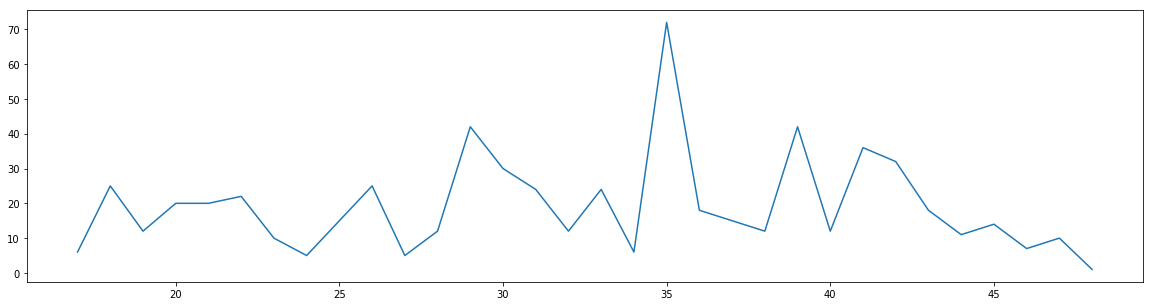

In [9]:
df['minute'].value_counts().sort_index().plot.line()

### Top ten users with more number of tweets. 

In [10]:
user_df = df.groupby('user_name').size().reset_index()
user_df = user_df.rename(columns = {0 :'count'})
user_df = user_df.sort_values(by = 'count', ascending = False)
user_df.head(10)

,user_name,count
8,ArkangelScrap,22
67,Rstats,18
17,Curious Luke,18
27,Dr. GP Pulipaka,17
64,Raymond460,17
22,DeepSingularity,17
73,Serverless Fan,17
59,PhoenixCodes,15
92,🇿🇦 Wynand Booysen 💻 改善,14
53,Mr Data Scientist,13


### Create a new column in the data itself, to identity total number of hashtags in each tweet. 

In [11]:
def hashtags(val):
    count = 0
    words = val.split(' ')
    for word in words:
        if word.startswith('#'):
            count = count + 1
    return count

df['count_hashtag'] = df['Message'].apply(hashtags)
df.head()

,Message,Created At,user_name,date,minute,count_hashtag
0,#Recommendations on #health and #treatments fo...,2019-10-03 04:41:01,Soulpage,2019-10-03 04:41:01,41,5
1,RT @GeniusCountry: DCVC’s biggest exits to dat...,2019-10-03 04:40:05,Gamer Geek,2019-10-03 04:40:05,40,0
2,RT @ProgrammerBooks: Migrating to Swift from F...,2019-10-03 04:40:03,Cool Go,2019-10-03 04:40:03,40,4
3,RT @Fisher85M: What is #OpenScience? {Infograp...,2019-10-03 04:39:57,Néxar Salazar,2019-10-03 04:39:57,39,7
4,"RT @gp_pulipaka: How to Calculate Precision, R...",2019-10-03 04:39:51,ArkangelScrap,2019-10-03 04:39:51,39,6


### Identity those users who have used '#datascience' as well as '#machinelearning'. Plot a bar chart of such top 10 users

In [12]:
def find_hashtags(val):
    words = val.split(' ')
    if '#machinelearning' or '#MachineLearning' in words:
        return 1
    else:
        return 0
    
df['is_tag'] = df['Message'].apply(find_hashtags)

In [13]:
hashtag_df = df.groupby('user_name')['is_tag'].sum().reset_index()
hashtag_df = hashtag_df.rename(columns = {'is_tag' : 'count'})
hashtag_df = hashtag_df.sort_values(by = 'count', ascending = False)
top_tags_df = hashtag_df.head(10)
top_tags_df

,user_name,count
8,ArkangelScrap,22
67,Rstats,18
17,Curious Luke,18
27,Dr. GP Pulipaka,17
64,Raymond460,17
22,DeepSingularity,17
73,Serverless Fan,17
59,PhoenixCodes,15
92,🇿🇦 Wynand Booysen 💻 改善,14
53,Mr Data Scientist,13


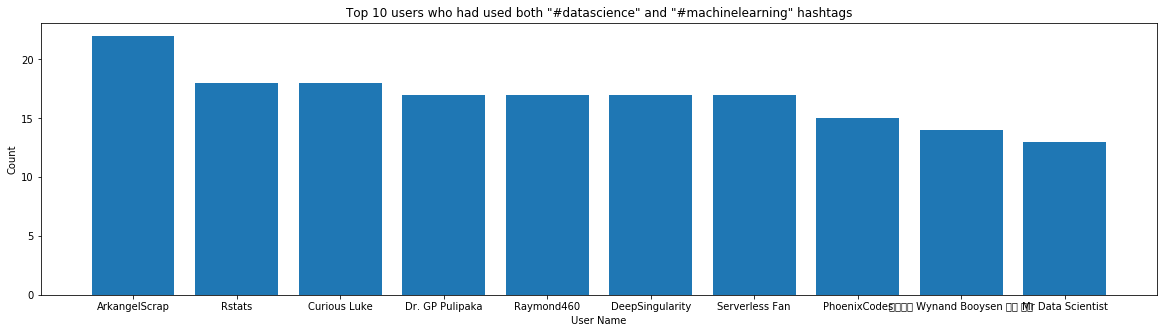

In [14]:
plt.bar(top_tags_df['user_name'], top_tags_df['count'])
plt.xlabel('User Name')
plt.ylabel('Count')
plt.title('Top 10 users who had used both "#datascience" and "#machinelearning" hashtags')
plt.show()

# Task 2: Using Narendra Modi’s tweet perform the following:

#### Tasks: Using VADER calculate the Sentiment score: 
        
    * Positive (score > 0.05)
    * Negative (score < -0.05)
    * Neutral (-0.05 <= score <= 0.05)
    * Use Naïve Bayes to predict the sentiment and calculate the accuracy score
    * Create a multi-line chart for comparing no. of positive, negative and neutral reviews for each day.
    * Classify the following tweet: 
        “India is a great country. It has one of the oldest civilizations. It has its own heritage culture. People from different caste, creed, religion, speaking different languages stay together. However, with all the political parties trying to get votes, India has seen various caste or religion-based riots and protests.”


In [18]:
modi_df = pd.read_csv(r'D:\NAYANA\Term 3\UDA\Assignment\Assignment 2\Assignment 2\narendramodi_tweets.csv')
modi_df.head(2)

,id,retweets_count,favorite_count,created_at,text,lang,retweeted,followers_count,friends_count,hashtags_count,description,location,background_image_url,source
0,8.260000e+17,1406,4903,31-01-2017 11:00,The President's address wonderfully encapsulat...,en,False,26809964,1641,1,Prime Minister of India,India,http://pbs.twimg.com/profile_background_images...,Twitter Web Client
1,8.260000e+17,907,2877,31-01-2017 10:59,Rashtrapati Ji's address to both Houses of Par...,en,False,26809964,1641,0,Prime Minister of India,India,http://pbs.twimg.com/profile_background_images...,Twitter Web Client


In [19]:
stop = np.array(stopwords.words('english'))

# Lets take the column review.text column

text = modi_df[['text', 'created_at']]
print(text['text'][0])

The President's address wonderfully encapsulated India's strengths, aspirations, potential &amp; the efforts towards #TransformingIndia.


In [21]:
senti = SentimentIntensityAnalyzer()

# Creating a function

text_pol = lambda text: senti.polarity_scores(text)['compound']

text['Polarity_score'] = text['text'].apply(text_pol)
text.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,text,created_at,Polarity_score
0,The President's address wonderfully encapsulat...,31-01-2017 11:00,0.7650
1,Rashtrapati Ji's address to both Houses of Par...,31-01-2017 10:59,0.0000
2,RT @PMOIndia: Empowering the marginalised. htt...,31-01-2017 10:52,0.0000
3,RT @PMOIndia: Commitment to welfare of farmers...,31-01-2017 10:52,0.3818
4,RT @PMOIndia: Improving the quality of life fo...,31-01-2017 10:52,-0.0772


In [22]:
dict = {1 : "Negative", 2 : "Netural", 3 : "Postive"}

map_sentiment = lambda val: np.digitize(val, [-1, -0.05, 0.05])
text['Result'] = text['Polarity_score'].apply(map_sentiment)

# Replacing the label by num

text['Sentiment'] = text['Result'].replace(dict)

text.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,text,created_at,Polarity_score,Result,Sentiment
0,The President's address wonderfully encapsulat...,31-01-2017 11:00,0.7650,3,Postive
1,Rashtrapati Ji's address to both Houses of Par...,31-01-2017 10:59,0.0000,2,Netural
2,RT @PMOIndia: Empowering the marginalised. htt...,31-01-2017 10:52,0.0000,2,Netural
3,RT @PMOIndia: Commitment to welfare of farmers...,31-01-2017 10:52,0.3818,3,Postive
4,RT @PMOIndia: Improving the quality of life fo...,31-01-2017 10:52,-0.0772,1,Negative


In [23]:
# Creating the train and test data

X = text['text']
Y = text['Result']

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [25]:
x_train.head()

727     RT @AkbaruddinIndia: Lighting up.\r\n@UN light...
271     Every #DigiDhanMela is a fine way of learning ...
2685    Sports complex inaugurated today will most cer...
369     There is a separate section on Mobile App dedi...
779     RT @MVenkaiahNaidu: #Sandesh2Soldiers Salute t...
Name: text, dtype: object

In [26]:
# Cleaning the data - removing punctuation, numbers, converting everything to lower case etc

x_train_new = x_train.str.replace('[^a-zA-Z ]', '')
x_train_new.head()

727     RT AkbaruddinIndia Lighting upUN lights up for...
271     Every DigiDhanMela is a fine way of learning a...
2685    Sports complex inaugurated today will most cer...
369     There is a separate section on Mobile App dedi...
779     RT MVenkaiahNaidu SandeshSoldiers Salute to ou...
Name: text, dtype: object

In [27]:
# Create a count vectorizer object

tfidf_vectorizer = TfidfVectorizer()

# Fit the count vectorizer using the text data

tfidf_vectorizer.fit(x_train)

# Collect the vocabulary items used in the vectorizer
dictionary = tfidf_vectorizer.vocabulary_.items() 

In [28]:
# Creating DTM

x_train_vec = tfidf_vectorizer.fit_transform(x_train)
x_train_vec

<2389x7759 sparse matrix of type '<class 'numpy.float64'>'
	with 41480 stored elements in Compressed Sparse Row format>

In [29]:
# Build the model

nb_model = MultinomialNB()

# Fitting the model
nb_model.fit(x_train_vec, y_train)

x_test_vec = tfidf_vectorizer.transform(x_test)
x_test_vec

<598x7759 sparse matrix of type '<class 'numpy.float64'>'
	with 9269 stored elements in Compressed Sparse Row format>

In [30]:
y_pred = nb_model.predict(x_test_vec)
y_pred

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [31]:
# Checking the accuracy

print(accuracy_score(y_test, y_pred))

0.697324414715719


In [32]:
text['date'] = pd.to_datetime(text['created_at'])
text['week'] = text['date'].dt.weekday_name
text.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,text,created_at,Polarity_score,Result,Sentiment,date,week
0,The President's address wonderfully encapsulat...,31-01-2017 11:00,0.7650,3,Postive,2017-01-31 11:00:00,Tuesday
1,Rashtrapati Ji's address to both Houses of Par...,31-01-2017 10:59,0.0000,2,Netural,2017-01-31 10:59:00,Tuesday
2,RT @PMOIndia: Empowering the marginalised. htt...,31-01-2017 10:52,0.0000,2,Netural,2017-01-31 10:52:00,Tuesday
3,RT @PMOIndia: Commitment to welfare of farmers...,31-01-2017 10:52,0.3818,3,Postive,2017-01-31 10:52:00,Tuesday
4,RT @PMOIndia: Improving the quality of life fo...,31-01-2017 10:52,-0.0772,1,Negative,2017-01-31 10:52:00,Tuesday


In [33]:
text['positive'] = text['Result'].map(lambda x:1 if x == 3 else 0)
text['netural'] = text['Result'].map(lambda x:1 if x == 2 else 0)
text['negative'] = text['Result'].map(lambda x:1 if x == 1 else 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [34]:
text_positive = text.groupby('week')['positive'].sum().reset_index()
text_negative = text.groupby('week')['negative'].sum().reset_index()
text_netural = text.groupby('week')['netural'].sum().reset_index()

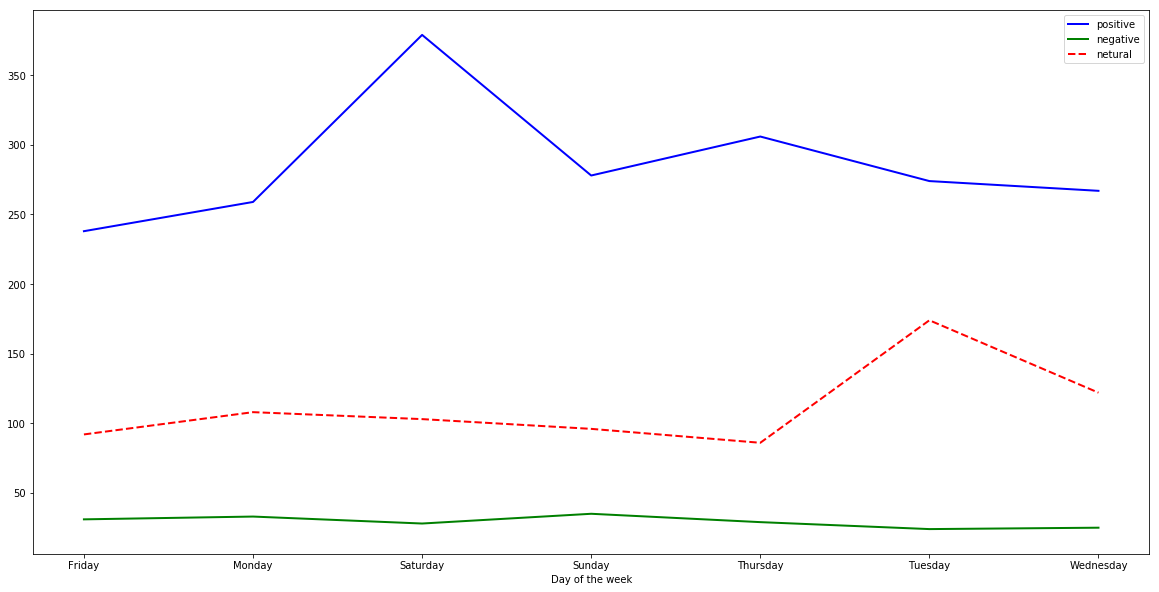

In [35]:
plt.rcParams['figure.figsize'] = (20,10)

# Multiple line plot

plt.plot( text_positive['week'], text_positive['positive'], color = 'blue', linewidth = 2)
plt.plot( text_negative['week'], text_negative['negative'], color = 'green', linewidth = 2)
plt.plot( text_netural['week'], text_netural['netural'], color = 'red', linewidth = 2, linestyle = 'dashed', label = 'netural')
plt.xlabel('Day of the week')
plt.legend()

In [36]:
str = '''India is a great country. It has one of the oldest civilizations. It has its own heritage culture. 
    People from different caste, creed, religion, speaking different languages stay together. However, with all the 
    political parties trying to get votes, India has seen various caste or religion-based riots and protests.'''
str

'India is a great country. It has one of the oldest civilizations. It has its own heritage culture. \n    People from different caste, creed, religion, speaking different languages stay together. However, with all the \n    political parties trying to get votes, India has seen various caste or religion-based riots and protests.'

In [37]:
new_str = str.replace('[^a-zA-Z ]', '')
df_str = pd.Series(new_str)
df_str

0    India is a great country. It has one of the ol...
dtype: object

In [38]:
x_val_vec = tfidf_vectorizer.transform(df_str)
x_val_vec

<1x7759 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [39]:
y_val_pred = nb_model.predict(x_val_vec)
y_val_pred

array([3], dtype=int64)

In [41]:
senti.polarity_scores(str)['compound']

0.3818

# ------------------------------------------------ END -------------------------------------------------------